In [1]:
!gdown 1-wm3Hj-9s0rmpUZGCNWJqSib12n2Df2P

Downloading...
From (original): https://drive.google.com/uc?id=1-wm3Hj-9s0rmpUZGCNWJqSib12n2Df2P
From (redirected): https://drive.google.com/uc?id=1-wm3Hj-9s0rmpUZGCNWJqSib12n2Df2P&confirm=t&uuid=3be408cd-f5c2-4f69-a74c-2dd0b0ea8eb1
To: /content/Copy of Copy of devnagari digit.zip
100% 16.6M/16.6M [00:00<00:00, 53.7MB/s]


In [2]:
!unzip Copy\ of\ Copy\ of\ devnagari\ digit.zip

Streaming output truncated to the last 5000 lines.
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10299.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10300.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10301.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10302.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10303.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10304.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10306.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/10307.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/104017.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/104018.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/104019.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/104021.png  
  inflating: DevanagariHandwrittenDigitDataset/Train/digit_7/104023.p

In [8]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set image directory
image_dir = '/content/DevanagariHandwrittenDigitDataset/Train' # adjust as needed
image_size = (32, 32)

def load_images_from_folder(folder, img_size):
    images = []
    for label in sorted(os.listdir(folder)):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)

                # ✅ Skip hidden/system files or directories
                if not os.path.isfile(img_path) or filename.startswith('.'):
                    continue

                try:
                    img = Image.open(img_path).convert('L').resize(img_size)
                    images.append(np.array(img))
                except Exception as e:
                    print(f"Skipped {img_path}: {e}")
    return np.array(images)

# Load and normalize
images = load_images_from_folder(image_dir, image_size)
images = images.astype('float32') / 255.0
images = np.expand_dims(images, axis=-1)

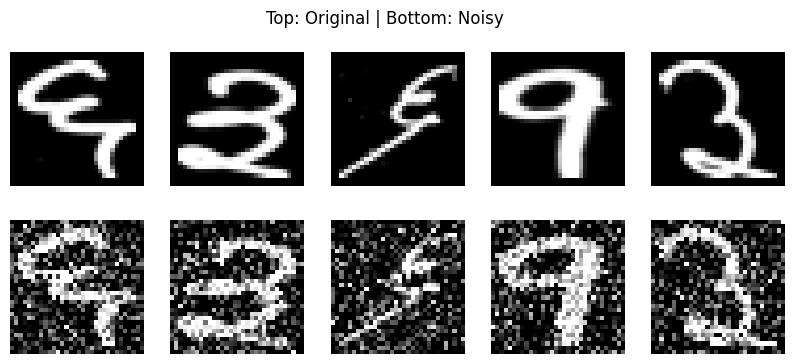

In [9]:
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

def add_gaussian_noise(x, noise_factor=0.4):
    noisy = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    return np.clip(noisy, 0., 1.)

x_train_noisy = add_gaussian_noise(x_train)
x_test_noisy = add_gaussian_noise(x_test)

# Visualize
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i].reshape(32, 32), cmap='gray')
    plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(x_test_noisy[i].reshape(32, 32), cmap='gray')
    plt.axis('off')
plt.suptitle("Top: Original | Bottom: Noisy")
plt.show()

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

def build_denoising_autoencoder(input_shape=(32, 32, 1)):
    input_img = Input(shape=input_shape)

    # Encoder (4 layers)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder (4 layers)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder

autoencoder = build_denoising_autoencoder()
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 61s 566ms/step - loss: 0.1547 - val_loss: 0.1489
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 52s 486ms/step - loss: 0.1490 - val_loss: 0.1457
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 85s 517ms/step - loss: 0.1453 - val_loss: 0.1433
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 80s 498ms/step - loss: 0.1433 - val_loss: 0.1418
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 81s 488ms/step - loss: 0.1417 - val_loss: 0.1411
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 53s 499ms/step - loss: 0.1407 - val_loss: 0.1397
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 83s 508ms/step - loss: 0.1400 - val_loss: 0.1391
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 81s 501ms/step - loss: 0.1390 - val_loss: 0.1389
Epoch 9/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 84s 519ms/step - loss: 0.1383 - val_loss: 0.1377
Epoch 10/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 522ms/step - loss: 0.1373 - val_loss: 0.1372
Epoch 11/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 56s 520ms/step - loss: 0.1373 - val_loss: 0.1368
Epoch 12/20
107/107

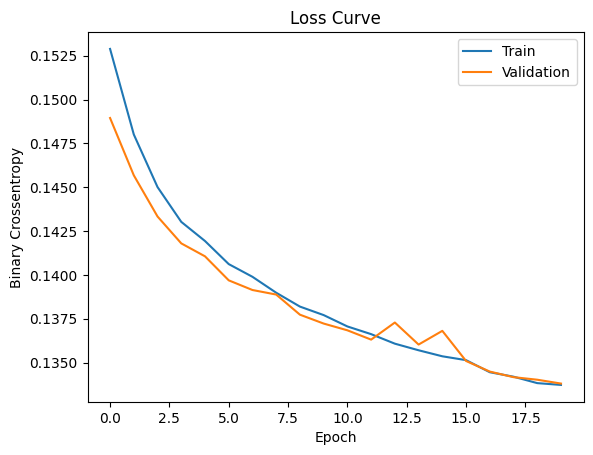

In [12]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

# Plot loss curve
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.show()

107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


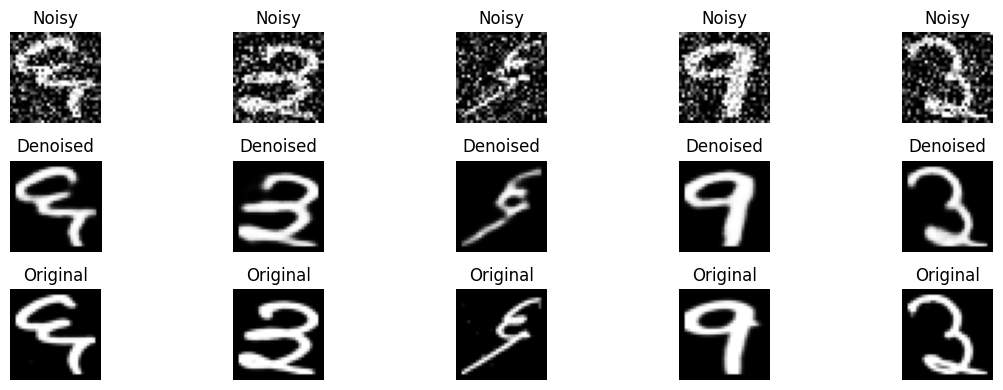

In [13]:
# Predict
denoised = autoencoder.predict(x_test_noisy)

# Plot sample results
def show_denoised(noisy, clean, denoised, n=5):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        # Noisy
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].reshape(32, 32), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoised
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised[i].reshape(32, 32), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        # Clean
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean[i].reshape(32, 32), cmap='gray')
        plt.title("Original")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_denoised(x_test_noisy, x_test, denoised, n=5)